<a href="https://colab.research.google.com/github/EmmanuelADAM/IntelligenceArtificiellePython/blob/master/TPClassificationLivres.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
---
# Classification de commentaires de livres (en français)

## Collection de données de critiques de films
Le tp utilisera l'ensemble de données issues de
[French Book reviews](https://www.kaggle.com/datasets/abireltaief/books-reviews) que vous devez télécharger.

Ce fichier CSV contient presque 10000 commentaires sur des livres, leurs notes, et l'avis (positif, négatif ou neutre).

---
Vous vous baserez sur la solution à *[Détection de "sentiments"](https://github.com/EmmanuelADAM/IntelligenceArtificiellePython/blob/master/SolutionTPDetectionDeSentiments.ipynb)*.

Vous adapterez le code présent pour traiter le texte en français.
Simpement, les "stopwords" seront chargés ainsi :

In [2]:
from os import listdir
import pandas as pd
from tqdm import tqdm

##import pour la creation de tokens
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize

##import pour la gestion de ponctuation
from string import punctuation

##import pour une collection spécifique : counter
from collections import Counter

##import pour les réseaux de neurones :
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

##import classique pour les tableaux efficaces
import numpy as np

In [3]:
nltk.download("stopwords")
stop_words = set(stopwords.words('french'))

Series = pd.core.series.Series
DataFrame = pd.core.frame.DataFrame

df = pd.read_json("hf://datasets/Abirate/french_book_reviews/french_books_reviews.jsonl", lines=True)
reader_reviews:Series = df["reader_review"]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


---
A partir de la colonne 'reader_review' plusieurs classements sont possibles :
- soit le classement de valeurs entre -1 et 1 (ce qui correspond à la colonne 'label')
- soit le classement par une note entre . et 5 (ce qui correspond à la colonne 'rating')

*N.B. la fonction d'activation sigmoid pren ses valeurs dans [0,1], l'activation en utilisant la tangente hyperboliquye 'tanh' prend ses valeus dans [-1, 1]*

In [4]:
def clean_doc(doc:str)->list:
    """retourne la liste de mots clés inclus dans le texte doc
    qui ne font pas parti des stop_words"""
    # split into tokens by white space
    tokens = wordpunct_tokenize(doc)
    # remove remaining tokens that are not alphabetic
    tokens = [word.lower() for word in tokens if word.isalpha()]
    # filter out stop words
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 2]
    return tokens

def add_doc_to_vocab(reader_review:str, vocab:Counter):
    """cumule dans la liste vocab les mots de la review
    (1 seule occurrence par mot dans vocab)"""
    # clean doc
    tokens = clean_doc(reader_review)
    # update counts
    vocab.update(tokens)

def build_voc(serie:Series, vocab:Counter):
    """ajoute au dictionnaire vocab les mots cles de 90% de la serie de données"""
    i=0
    nb = int(serie.size)
    # walk through all files in the folder
    for i in tqdm(range(nb)):
        # add doc to vocab
        add_doc_to_vocab(serie[i], vocab)

In [5]:
# creer un vocabulaire (liste de mots clés associés à leurs occurrences)
vocab:Counter = Counter()
build_voc(reader_reviews, vocab)
# afficher le nb de mots cles trouves
print("nb de mots cles trouves dans les repertoires : ", len(vocab))
print("les 10 premiers mots cles du vocabulaire \
(et leur nb d\'apparition dans les exemples)  : \n", end='')
i:int=0
for (mot,count) in vocab.items():
    print(mot,':',count,end=", ")
    i = i+1
    if i>10:break
# afficher les 10 mots cles les plus utilises
print("\nles 10 mots cles les plus utilises : ", vocab.most_common(10))

100%|██████████| 9658/9658 [00:00<00:00, 19681.98it/s]

nb de mots cles trouves dans les repertoires :  33512
les 10 premiers mots cles du vocabulaire (et leur nb d'apparition dans les exemples)  : 
premier : 666, roman : 2083, aborder : 32, thèmes : 72, lourds : 5, inceste : 6, enfance : 141, martyre : 1, fait : 1339, audace : 10, brio : 22, 
les 10 mots cles les plus utilises :  [('plus', 2435), ('livre', 2380), ('cette', 2223), ('tout', 2097), ('roman', 2083), ('histoire', 1978), ('bien', 1853), ('très', 1814), ('fait', 1339), ('comme', 1273)]


In [6]:
#Ajout de stop words
stop_words.add('livre')
stop_words.add('cette')
stop_words.add('roman')
stop_words.add('comme')
stop_words.add('histoire')
stop_words.add('être')
stop_words.add('tout')
stop_words.add('lecture')
stop_words.add('fait')
stop_words.add('personnages')
stop_words.add('tome')
stop_words.add('deux')
stop_words.add('aussi')
stop_words.add('lire')
stop_words.add('auteur')
stop_words.add('faire')
stop_words.add('entre')
stop_words.add('après')
stop_words.add('avoir')

In [7]:
#verification en recréant un vocabulaire (liste de mots clés associés à leurs occurrences)
vocab:Counter = Counter()
build_voc(reader_reviews, vocab)
# afficher le nb de mots cles trouves
print("nb de mots cles trouves dans les repertoires : ", len(vocab))
print("les 10 premiers mots cles du vocabulaire \
(et leur nb d\'apparition dans les exemples)  : \n", end='')
i:int=0
for (mot,count) in vocab.items():
    print(mot,':',count,end=", ")
    i = i+1
    if i>10:break
# afficher les 10 mots cles les plus utilises
print("\nles 10 mots cles les plus utilises : ", vocab.most_common(10))

100%|██████████| 9658/9658 [00:00<00:00, 12007.68it/s]

nb de mots cles trouves dans les repertoires :  33493
les 10 premiers mots cles du vocabulaire (et leur nb d'apparition dans les exemples)  : 
premier : 666, aborder : 32, thèmes : 72, lourds : 5, inceste : 6, enfance : 141, martyre : 1, audace : 10, brio : 22, incomparables : 1, rendent : 22, 
les 10 mots cles les plus utilises :  [('plus', 2435), ('bien', 1853), ('très', 1814), ('peu', 1167), ('vie', 1031), ('sans', 970), ('beaucoup', 912), ('premier', 666), ('petit', 663), ('temps', 649)]


In [8]:
# ne garder que les mots clés apparaissant au moins x fois
min_occurrence:int = 50
tokens:list = [token for (token,count) in vocab.items() if count >= min_occurrence]
print('en otant les mots utilise moins de ', min_occurrence, ' fois,',
      ' nb de mots cles = ',len(tokens))

en otant les mots utilise moins de  50  fois,  nb de mots cles =  840


In [9]:
def save_list(lines:list, filename:str):
    """sauve les mots de la liste de commentaires lines dans le fichier filename"""
    # convert lines to a single blob of text
    data = '\n'.join(lines)
    # open file
    file = open(filename, 'w')
    # write text
    file.write(data)
    # close file
    file.close()

rep = '/content/'

# save tokens to a vocabulary file
save_list(tokens, rep+'vocab.txt')

def load_doc(filename:str)->str:
    """retourne le texte inclu dans le fichier filename"""
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

def vocab_in_doc(texte:str, vocab:list)->list:
    """retourne la liste des mots cles du texte qui appartenant au vocabulaire vocab"""
    # clean doc
    tokens = clean_doc(texte)
    # filter by vocab
    tokens = [token for token in tokens if token in vocab]
    return ' '.join(tokens)

def process_docs(serie:list, vocab:list)->list:
    """retourne une listes des mots cles des textes contenu dans la serie de texte"""
    lines = list()

    nb = int(serie.size*0.9)
    # walk through all files in the folder
    for i in tqdm(range(serie.size)):
        line = vocab_in_doc(serie[i], vocab)
        lines.append(line)
    return lines

vocab_filename = 'vocab.txt'
vocab = load_doc(rep+vocab_filename)
vocab = vocab.split()
vocab = set(vocab)

reader_reviews = reader_reviews[:10000]

# load training and testing reviews
lines_input:list = process_docs(reader_reviews, vocab)
nb_input:int = len(lines_input)

# summarize what we have
print("nb exemples : ", nb_input)

100%|██████████| 9658/9658 [00:00<00:00, 21288.33it/s]

nb exemples :  9658


In [10]:
# create the tokenizer
tokenizer = keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(lines_input)
xTrain:np.ndarray = tokenizer.texts_to_matrix(lines_input, mode='freq')

In [11]:
print('Xtrain contient ', xTrain.shape[0], ' exemples de ', xTrain.shape[1], ' valeurs')
print('une valeur = fréquence d\'apparition des mots dans le vocabulaire global.')
print('Ainsi, premier exemple d\'entrainement = \n', xTrain[0])

Xtrain contient  9658  exemples de  841  valeurs
une valeur = fréquence d'apparition des mots dans le vocabulaire global.
Ainsi, premier exemple d'entrainement = 
 [0.   0.04 0.   0.   0.   0.08 0.   0.   0.04 0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.04 0.   0.   0.04 0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.04 0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.04 0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.04 0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.08 0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.04 0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.04 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.

In [12]:
np.sum(xTrain[0])

np.float64(1.0)

In [13]:
labels:Series  = df['label']
labels_output:Series = labels[:nb_input]
yOutput:np.ndarray = np.zeros((nb_input, 1))
for i in range(nb_input):
    if labels_output[i]=='positive': yOutput[i]=1

In [14]:
#le nb de neurones en entrée (= nb de tokens retenus)
n_words = xTrain.shape[1]
n_words

841

In [15]:
#  définir la structure du réseau
model = Sequential()
model.add(Dense(n_words//3, input_shape=(n_words,), activation='elu'))
model.add(Dense(n_words//27, activation='elu'))
model.add(Dense(n_words//243, activation='elu'))
model.add(Dense(1, activation='sigmoid'))
# compile network
model.compile(loss='hinge', optimizer='adam',  metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
#TODO tester differents nb de tests (epochs)
history = model.fit(xTrain, yOutput,
                    validation_split = 0.1,
#                    validation_data=(xTest, yTest),
                    batch_size=500,
#                    steps_per_epoch=10,
                    epochs=10,
                    verbose=2)

Epoch 1/10
18/18 - 2s - 113ms/step - accuracy: 0.9739 - loss: 1.2795 - val_accuracy: 1.0000 - val_loss: 1.0546
Epoch 2/10
18/18 - 0s - 18ms/step - accuracy: 1.0000 - loss: 1.0169 - val_accuracy: 1.0000 - val_loss: 1.0034
Epoch 3/10
18/18 - 0s - 18ms/step - accuracy: 1.0000 - loss: 1.0018 - val_accuracy: 1.0000 - val_loss: 1.0013
Epoch 4/10
18/18 - 0s - 18ms/step - accuracy: 1.0000 - loss: 1.0009 - val_accuracy: 1.0000 - val_loss: 1.0009
Epoch 5/10
18/18 - 1s - 34ms/step - accuracy: 1.0000 - loss: 1.0007 - val_accuracy: 1.0000 - val_loss: 1.0008
Epoch 6/10
18/18 - 0s - 17ms/step - accuracy: 1.0000 - loss: 1.0006 - val_accuracy: 1.0000 - val_loss: 1.0007
Epoch 7/10
18/18 - 1s - 35ms/step - accuracy: 1.0000 - loss: 1.0005 - val_accuracy: 1.0000 - val_loss: 1.0006
Epoch 8/10
18/18 - 1s - 35ms/step - accuracy: 1.0000 - loss: 1.0004 - val_accuracy: 1.0000 - val_loss: 1.0005
Epoch 9/10
18/18 - 1s - 33ms/step - accuracy: 1.0000 - loss: 1.0004 - val_accuracy: 1.0000 - val_loss: 1.0004
Epoch 10/

In [17]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

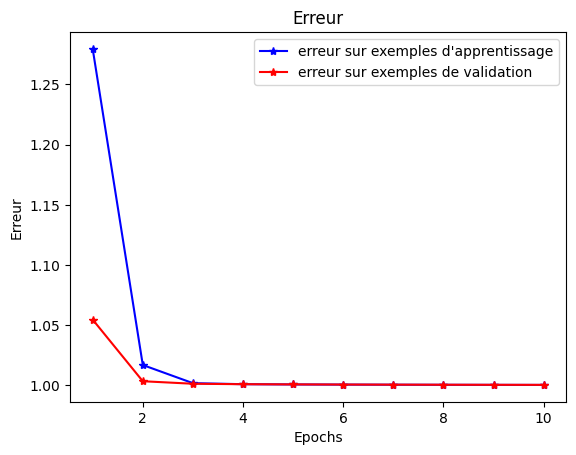

In [19]:
import matplotlib.pyplot as plt

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

# draw the loss evolution in blue
plt.plot(epochs, loss, 'b-*', label='erreur sur exemples d\'apprentissage')
# draw the accuracy evolution in blue
plt.plot(epochs, val_loss, 'r-*', label='erreur sur exemples de validation')
plt.title('Erreur')
plt.xlabel('Epochs')
plt.ylabel('Erreur')
plt.legend()

plt.show()

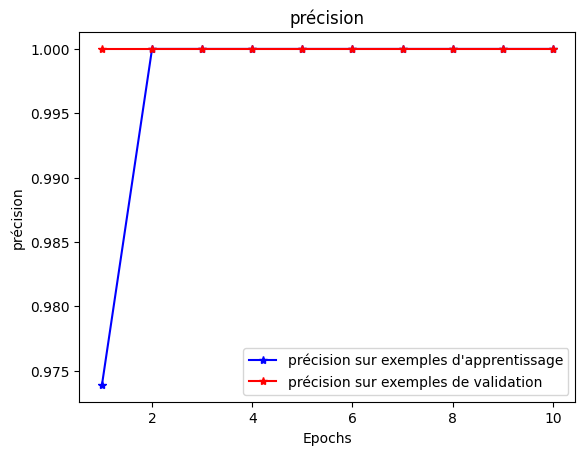

In [20]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(loss) + 1)

# draw the loss evolution in blue
plt.plot(epochs, acc, 'b-*', label='précision sur exemples d\'apprentissage')
# draw the accuracy evolution in blue
plt.plot(epochs, val_acc, 'r-*', label='précision sur exemples de validation')
plt.title('précision')
plt.xlabel('Epochs')
plt.ylabel('précision')
plt.legend()

plt.show()

In [21]:
def predict_label(review, vocab, tokenizer, model):
    """classifie le texte dans la variable 'review' en positif (0) ou negatif (1) """
    # clean
    tokens = clean_doc(review)
    # filter by vocab
    tokens = [w for w in tokens if w in vocab]
    # convert to line
    line = ' '.join(tokens)
    # create the bag of words with the words used in the line
    encoded = tokenizer.texts_to_matrix([line], mode='freq')
    # prediction, output is a vector of (1x1) here (output of the neural network is a vector of 1 element)
    output = model.predict(encoded, verbose=0)
    estimation = output[0,0]
    return estimation

In [24]:
# test
text = "Je n’ai pas appris beaucoup de nouvelles choses en lisant ce livre, mais il a l’avantage de rappeler l’histoire du RN et de l’extrême droite, et les conséquences d’une potentielle accession au pouvoir. Les arguments sont clairs et étayés et c’est très agréable.J’ai aussi apprécié la dernière partie, sur l’importance de s’investir en tant que citoyen pour faire vivre le dialogue et la démocratie"
resultat = predict_label(text, vocab, tokenizer, model)
print('\'',text,'\'\n ------> est considere comme ', 'positif' if resultat>0.5 else 'negatif')
print(resultat)

text = "J'ai laissé passé du temps avec de lire le 3ème tome, car j'avais trouvé \"Il était deux fois\" redondant avec le tome 1. Cela a été bénéfique, car j'ai eu plus de facilité à passer outre les répétitions de scènes de dépravation et de violence, qui ont tendance à me lasser, et j'ai pu apprécier le mécanisme de récit à 4 narratrices."
resultat = predict_label(text, vocab, tokenizer, model)
print('\'',text,'\'\n ------> est considere comme ', 'positif' if resultat>0.5 else 'negatif')
print(resultat)

' Je n’ai pas appris beaucoup de nouvelles choses en lisant ce livre, mais il a l’avantage de rappeler l’histoire du RN et de l’extrême droite, et les conséquences d’une potentielle accession au pouvoir. Les arguments sont clairs et étayés et c’est très agréable.J’ai aussi apprécié la dernière partie, sur l’importance de s’investir en tant que citoyen pour faire vivre le dialogue et la démocratie '
 ------> est considere comme  negatif
0.00010003606
' J'ai laissé passé du temps avec de lire le 3ème tome, car j'avais trouvé "Il était deux fois" redondant avec le tome 1. Cela a été bénéfique, car j'ai eu plus de facilité à passer outre les répétitions de scènes de dépravation et de violence, qui ont tendance à me lasser, et j'ai pu apprécier le mécanisme de récit à 4 narratrices. '
 ------> est considere comme  negatif
0.00011753146
